In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import catboost as cat
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("../../datasets/coffee_shop_dataset/coffee_shop_revenue.csv")
target = "Daily_Revenue"

num_features = list(df.select_dtypes(exclude='object'))
num_features.remove(target)
cat_features = list(df.select_dtypes(include='object'))
catboost_features = num_features+cat_features

# Dataset preprocessing

In [3]:
df.loc[:, num_features] = df.loc[:, num_features].fillna(0)
df.loc[:, cat_features] = df.loc[:, cat_features].fillna('Other')

In [4]:
enc = OneHotEncoder(sparse_output=False, drop='first')
encoded_cat_df = enc.fit_transform(df[cat_features])
encoded_cat_df = pd.DataFrame(encoded_cat_df, columns=enc.get_feature_names_out(cat_features)).astype('Int16')
encoded_cat_features = list(encoded_cat_df.columns)
encoded_cat_df.shape

(2000, 0)

In [5]:
encoded_df = pd.concat([df, encoded_cat_df], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_df[num_features+cat_features+encoded_cat_features], 
    encoded_df[target], 
    test_size=0.33, random_state=2025)

df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [7]:
linear_features = num_features+encoded_cat_features

In [8]:
scaler = MinMaxScaler()
scaled_df_train = scaler.fit_transform(df_train[linear_features])
scaled_df_train = pd.DataFrame(scaled_df_train, columns=linear_features)
scaled_df_train = pd.concat([scaled_df_train, df_train[[target]+ cat_features]], axis=1)

scaled_df_test = scaler.transform(df_test[linear_features])
scaled_df_test = pd.DataFrame(scaled_df_test, columns=linear_features)
scaled_df_test = pd.concat([scaled_df_test, df_test[[target]+ cat_features]], axis=1)

# Simple Linear Regression

In [9]:
result_metrics = pd.DataFrame(columns=[
     'algorithm',
     'dataset_type',
     'R2',
     'MSE',
     'RMSE',
     'MAE',
     'MAPE'
])

In [10]:
def get_metrics(y_true, y_pred, algorithm, dataset_type, res_df=None):
    res_df = res_df.copy()
    
    r2 = metrics.r2_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

    print(f"{algorithm}, -- Type Dataset - {dataset_type}")
    print(f"R2 = {r2}")
    print(f"MSE = {mse}")
    print(f"RMSE = {mse**0.5}")
    print(f"MAE = {mae}")
    print(f"MAPE = {mape}")
    
    curr_res = [algorithm, dataset_type] + [r2, mse, mse**0.5, mae, mape]
    res_df = pd.concat([res_df,
                        pd.DataFrame([curr_res], columns=['algorithm',
                                                            'dataset_type',
                                                            'R2',
                                                            'MSE',
                                                            'RMSE',
                                                            'MAE',
                                                            'MAPE'])])
    return res_df

In [11]:
from sklearn.linear_model import HuberRegressor

# loss='epsilon_insensitive' эквивалентен MAE при epsilon=0
simple_model = HuberRegressor(epsilon=1.35)
simple_model.fit(scaled_df_train[linear_features], scaled_df_train[target])

HuberRegressor()

In [12]:
preds_train = simple_model.predict(scaled_df_train[linear_features])
preds_test = simple_model.predict(scaled_df_test[linear_features])

In [13]:
result_metrics = get_metrics(scaled_df_train[target], preds_train, 
                              algorithm='simple_regression', dataset_type='train', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - train
R2 = 0.8922667274266651
MSE = 103392.83741705923
RMSE = 321.54756633670735
MAE = 252.25593982288717
MAPE = 0.19708086081365078


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_37439/2903524573.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,


In [14]:
result_metrics = get_metrics(scaled_df_test[target], preds_test, 
                              algorithm='simple_regression', dataset_type='test', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - test
R2 = 0.8890064775010744
MSE = 104092.0196650065
RMSE = 322.63294882111234
MAE = 254.3491354690157
MAPE = 0.19527601175954648


In [15]:
result_metrics

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.892267,103392.837417,321.547566,252.255940,0.197081
0,simple_regression,test,0.889006,104092.019665,322.632949,254.349135,0.195276


# Combine with classifier after k-means

## fit k-means 2 clusters on target

### clustering

In [16]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[[target]])
clf_target ='kmeans'

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

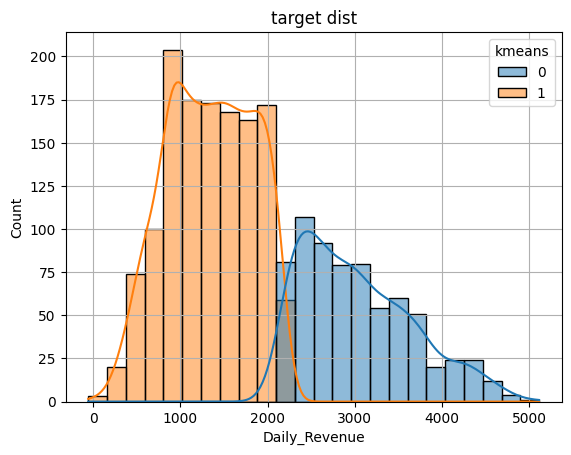

In [17]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [18]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [19]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       461
           1       0.99      1.00      0.99       879

    accuracy                           0.99      1340
   macro avg       0.99      0.99      0.99      1340
weighted avg       0.99      0.99      0.99      1340



In [20]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       228
           1       0.95      0.95      0.95       432

    accuracy                           0.94       660
   macro avg       0.93      0.93      0.93       660
weighted avg       0.94      0.94      0.94       660



### fit regression

In [21]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [22]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (461, 8) (879, 8)
test (227, 9) (433, 9)


In [23]:
lr_0 = HuberRegressor(epsilon=1.35)
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = HuberRegressor(epsilon=1.35)
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [24]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2_regression, -- Type Dataset - train
R2 = 0.9409020428308881
MSE = 56716.97639285009
RMSE = 238.1532624022818
MAE = 190.0541652826868
MAPE = 0.1563720466800032
segm_kmeans2_regression, -- Type Dataset - test
R2 = 0.9351898917250961
MSE = 60780.25918231219
RMSE = 246.53652707522306
MAE = 197.51001123221457
MAPE = 0.14187940383394634


## fit k-means 3  clusters on target

### clustering

In [25]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[[target]])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

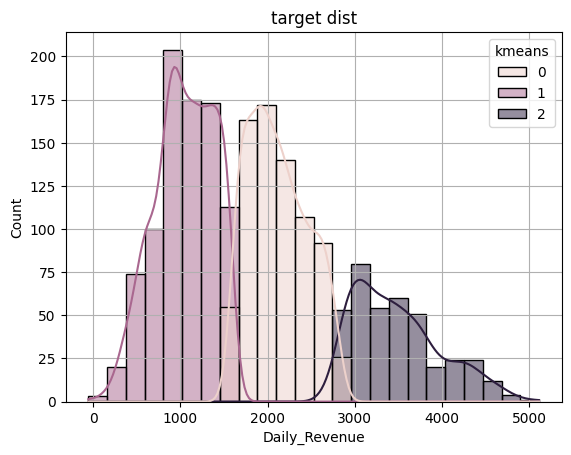

In [26]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [27]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [28]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       509
           1       1.00      1.00      1.00       579
           2       1.00      1.00      1.00       252

    accuracy                           1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



In [29]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       246
           1       0.91      0.93      0.92       283
           2       0.97      0.85      0.91       131

    accuracy                           0.90       660
   macro avg       0.91      0.89      0.90       660
weighted avg       0.90      0.90      0.90       660



### fit regression

In [30]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [31]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (509, 8) (579, 8) (252, 8)
test (253, 9) (291, 9) (116, 9)


In [32]:
lr_0 = HuberRegressor(epsilon=1.35)
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = HuberRegressor(epsilon=1.35)
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = HuberRegressor(epsilon=1.35)
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [33]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3_regression, -- Type Dataset - train
R2 = 0.9560537518772197
MSE = 42175.71023989277
RMSE = 205.36725698098218
MAE = 163.8250932222088
MAPE = 0.13832100871948677
segm_kmeans3_regression, -- Type Dataset - test
R2 = 0.936652781120394
MSE = 59408.33126909051
RMSE = 243.7382433453776
MAE = 195.7765957477334
MAPE = 0.13299287336289067


## fit 2 clusters on features

### clustering

In [34]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

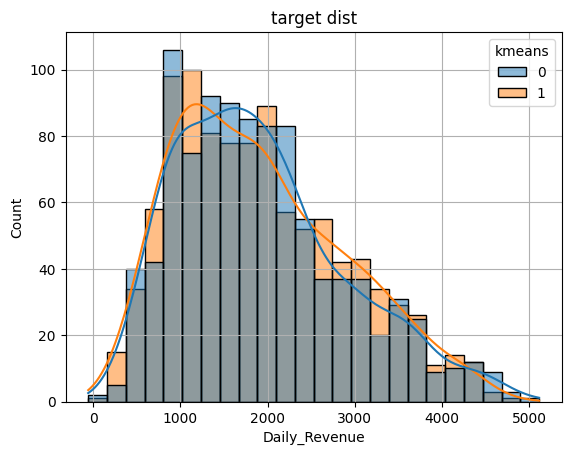

In [35]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [36]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [37]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       683

    accuracy                           1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



In [38]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       332
           1       0.98      0.99      0.99       328

    accuracy                           0.99       660
   macro avg       0.99      0.99      0.99       660
weighted avg       0.99      0.99      0.99       660



### fit regression

In [39]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [40]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (657, 8) (683, 8)
test (331, 9) (329, 9)


In [41]:
lr_0 = HuberRegressor(epsilon=1.35)
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = HuberRegressor(epsilon=1.35)
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [42]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2onFeatures_regression, -- Type Dataset - train
R2 = 0.8923773275990222
MSE = 103286.69318356783
RMSE = 321.38247180511854
MAE = 251.45419958602523
MAPE = 0.19671308015819303
segm_kmeans2onFeatures_regression, -- Type Dataset - test
R2 = 0.8882261848568768
MSE = 104823.79423559077
RMSE = 323.7650293586242
MAE = 255.45229995144248
MAPE = 0.19713046584234126


## fit 3 clusters on features

### clustering

In [43]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

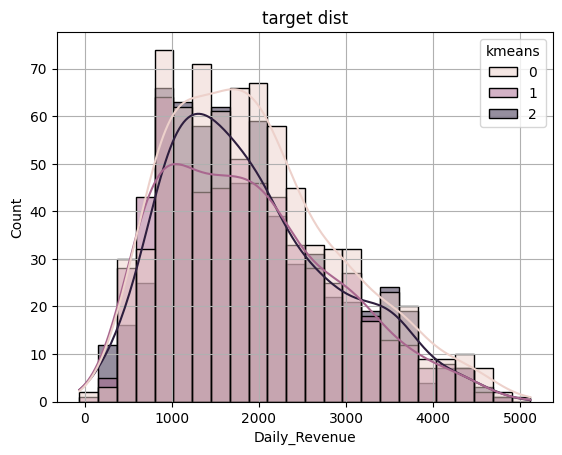

In [44]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [45]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [46]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       1.00      1.00      1.00       401
           2       1.00      1.00      1.00       419

    accuracy                           1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



In [47]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       246
           1       0.97      0.96      0.97       200
           2       0.96      0.97      0.97       214

    accuracy                           0.97       660
   macro avg       0.97      0.97      0.97       660
weighted avg       0.97      0.97      0.97       660



### fit regression

In [48]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [49]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (520, 8) (401, 8) (419, 8)
test (247, 9) (198, 9) (215, 9)


In [50]:
lr_0 =HuberRegressor(epsilon=1.35)
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = HuberRegressor(epsilon=1.35)
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = HuberRegressor(epsilon=1.35)
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [51]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3onFeatures_regression, -- Type Dataset - train
R2 = 0.8934296649106208
MSE = 102276.75319040596
RMSE = 319.8073688807154
MAE = 250.21772981998558
MAPE = 0.19371697671448143
segm_kmeans3onFeatures_regression, -- Type Dataset - test
R2 = 0.8846491171633881
MSE = 108178.44225748132
RMSE = 328.90491370224515
MAE = 258.33774571573707
MAPE = 0.19900500242807784


# Catboost

In [52]:
catboost_features = num_features+cat_features

In [53]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

def objective(trial, X, y):
    # Разделение данных на train и validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)
    
    # Параметры для перебора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': 'Plain',
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255),
        'eval_metric': 'RMSE',  # Метрика для регрессии
        'loss_function': 'RMSE',  # Функция потерь
        'task_type': 'CPU',
        'verbose': False,
        'random_state': 2025,
    }
    
    # Параметры глубины
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 4, 64)
    elif params['grow_policy'] == 'Depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 12)
    
    # Указание категориальных признаков (если есть)
    if cat_features:
        params['cat_features'] = cat_features
    
    # Создание и обучение модели
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=0
    )
    
    # Предсказание на валидации
    y_pred = model.predict(X_val)
    
    # Метрика качества (можно выбрать другую)
    rmse = metrics.mean_squared_error(y_val, y_pred)**0.5
    # Или можно использовать R2: return r2_score(y_val, y_pred)
    return rmse

# Пример использования:
study = optuna.create_study(direction='minimize')  # Для RMSE минимизируем
study.optimize(lambda trial: objective(trial, 
                                     scaled_df_train[catboost_features], 
                                     scaled_df_train[target]), 
                                     n_trials=50)
best_params = study.best_params

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-23 22:58:35,963] A new study created in memory with name: no-name-2d56c5b2-ec17-42e6-bc5d-b8ebffbd658b
[I 2025-04-23 22:58:36,742] Trial 0 finished with value: 311.89381698511005 and parameters: {'iterations': 1346, 'learning_rate': 0.001658553865791785, 'l2_leaf_reg': 2.2785656934798575, 'random_strength': 3.252430415694398, 'bagging_temperature': 4.227421630372728, 'border_count': 73, 'min_data_in_leaf': 27, 'leaf_estimation_iterations': 13, 'grow_policy': 'SymmetricTree', 'od_type': 'Iter', 'od_wait': 30, 'one_hot_max_size': 142}. Best is trial 0 with value: 311.89381698511005.
[I 2025-04-23 22:58:37,139] Trial 1 finished with value: 215.7138895747778 and parameters: {'iterations': 921, '

In [54]:
cat_model = cat.CatBoostRegressor(**best_params, cat_features = cat_features, verbose = False,
        random_state= 2025, boosting_type='Plain')
cat_model.fit(df_train[catboost_features], df_train[target])

In [55]:
y_train_pred = cat_model.predict(df_train[catboost_features])
y_test_pred = cat_model.predict(df_test[catboost_features])

In [56]:
result_metrics = get_metrics(df_train[target], y_train_pred,
                              algorithm='catboost_regression', dataset_type='train', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - train
R2 = 0.9666953990970955
MSE = 31962.801316093508
RMSE = 178.78143448382303
MAE = 142.24106238699497
MAPE = 0.1123434382809482


In [57]:
result_metrics = get_metrics(df_test[target], y_test_pred,
                              algorithm='catboost_regression', dataset_type='test', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - test
R2 = 0.9545241006145873
MSE = 42648.23844252775
RMSE = 206.51449935180761
MAE = 166.55426253403706
MAPE = 0.11706691590106719


In [58]:
result_metrics.query('dataset_type == "train"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.892267,103392.837417,321.547566,252.255940,0.197081
0,segm_kmeans2_regression,train,0.940902,56716.976393,238.153262,190.054165,0.156372
0,segm_kmeans3_regression,train,0.956054,42175.710240,205.367257,163.825093,0.138321
0,segm_kmeans2onFeatures_regression,train,0.892377,103286.693184,321.382472,251.454200,0.196713
0,segm_kmeans3onFeatures_regression,train,0.893430,102276.753190,319.807369,250.217730,0.193717
0,catboost_regression,train,0.966695,31962.801316,178.781434,142.241062,0.112343


In [59]:
result_metrics.query('dataset_type == "test"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,test,0.889006,104092.019665,322.632949,254.349135,0.195276
0,segm_kmeans2_regression,test,0.935190,60780.259182,246.536527,197.510011,0.141879
0,segm_kmeans3_regression,test,0.936653,59408.331269,243.738243,195.776596,0.132993
0,segm_kmeans2onFeatures_regression,test,0.888226,104823.794236,323.765029,255.452300,0.197130
0,segm_kmeans3onFeatures_regression,test,0.884649,108178.442257,328.904914,258.337746,0.199005
0,catboost_regression,test,0.954524,42648.238443,206.514499,166.554263,0.117067
